# This notebook has the essential simulation code for the paper "Sequential analysis and its applications to neuromorphic engineering"

## Event-Pixel / Skellam Random Walk Simulation

<pre>
This simulates the random walk,
                        S_{t+1} = S_t + Poisson(L_1) − Poisson(L_2), with absorbing boundaries b and a.
</pre>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift

In [5]:
def simulate_skellam_rw(L1, L2, S0, a, b, trials=10000, rng=None):
    """
    Simulate a Skellam random walk hitting-time problem:
        S_{t+1} = S_t + Pois(L1) - Pois(L2)
    until S_t >= a or S_t <= b.

    Returns:
        Ta: list of hitting times for upper boundary
        Tb: list of hitting times for lower boundary
    """
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []

    for _ in range(trials):
        S = S0
        T = 0
        while b < S < a:
            step = rng.poisson(L1) - rng.poisson(L2)
            S += step
            T += 1
        if S >= a:
            Ta.append(T)
        else:
            Tb.append(T)
    return np.array(Ta), np.array(Tb)


# Example usage
L1 = 1.02
L2 = 1.0
phi0 = 200
a = 2 * phi0
b = 0.5 * phi0
S0 = phi0

Ta, Tb = simulate_skellam_rw(L1, L2, S0, a, b, trials=1000)
print("Upper-bound hits:", len(Ta))
print("Lower-bound hits:", len(Tb))
print("Empirical alpha:", len(Ta) / (len(Ta) + len(Tb)))


Upper-bound hits: 869
Lower-bound hits: 131
Empirical alpha: 0.869


## Linear Voltage Model (dV = c_1(Pois(L_1)-Pois(L_2)) + c_2)

In [7]:
def simulate_linear_voltage(L1, L2, c1, c2, S0, a, b, trials=20000, rng=None):
    """
    Simulate the process:
        S_{t+1} = S_t + c1*(Pois(L1) - Pois(L2)) + c2
    until thresholds are crossed.

    Returns:
        Ta, Tb: arrays of hitting times
    """
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []

    for _ in range(trials):
        S = S0
        T = 0
        while b < S < a:
            step = c1 * (rng.poisson(L1) - rng.poisson(L2)) + c2
            S += step
            T += 1
        if S >= a:
            Ta.append(T)
        else:
            Tb.append(T)
    return np.array(Ta), np.array(Tb)


# Example usage
phi0 = 200
S0 = phi0
a = 3 * phi0
b = 0.9 * phi0

L1 = 1.0
L2 = 1.0
c1 = 1.22
c2 = 0.10

Ta, Tb = simulate_linear_voltage(L1, L2, c1, c2, S0, a, b, trials=1000)
print("Empirical alpha:", len(Ta) / (len(Ta) + len(Tb)))


Empirical alpha: 0.77


## SPRT / Sequential Log-Likelihood Accumulation

<pre>
Generic log-likelihood increment process:
                        S_{t+1} = S_t + l(X_t), with thresholds a and b
</pre>

In [20]:
def simulate_sprt(increment_fn, S0, a, b, trials=20000, rng=None):
    """
    Generic SPRT simulator.
    
    increment_fn(rng) -> single log-likelihood increment l(X)
    """
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []

    for _ in range(trials):
        S = S0
        T = 0
        while b < S < a:
            S += increment_fn(rng)
            T += 1
        if S >= a:
            Ta.append(T)
        else:
            Tb.append(T)
    return np.array(Ta), np.array(Tb)


# Example: Bernoulli-H0 vs Bernoulli-H1
p0 = 0.4
p1 = 0.6

def bernoulli_ll_increment(rng):
    x = rng.random() < p1     # simulate under H1 or whichever distribution of interest
    # log-likelihood increment log( P(x|H1) / P(x|H0) )
    return np.log(p1/p0) if x else np.log((1-p1)/(1-p0))


# Example usage
S0 = 0
a = 20
b = -1

Ta, Tb = simulate_sprt(bernoulli_ll_increment, S0, a, b, trials=1000)
print("Upper/lower hits:", len(Ta), len(Tb))
print("Empirical alpha:", len(Ta) / (len(Ta) + len(Tb)))


Upper/lower hits: 706 294
Empirical alpha: 0.706


## Skellam Random Walk — Empirical Figure

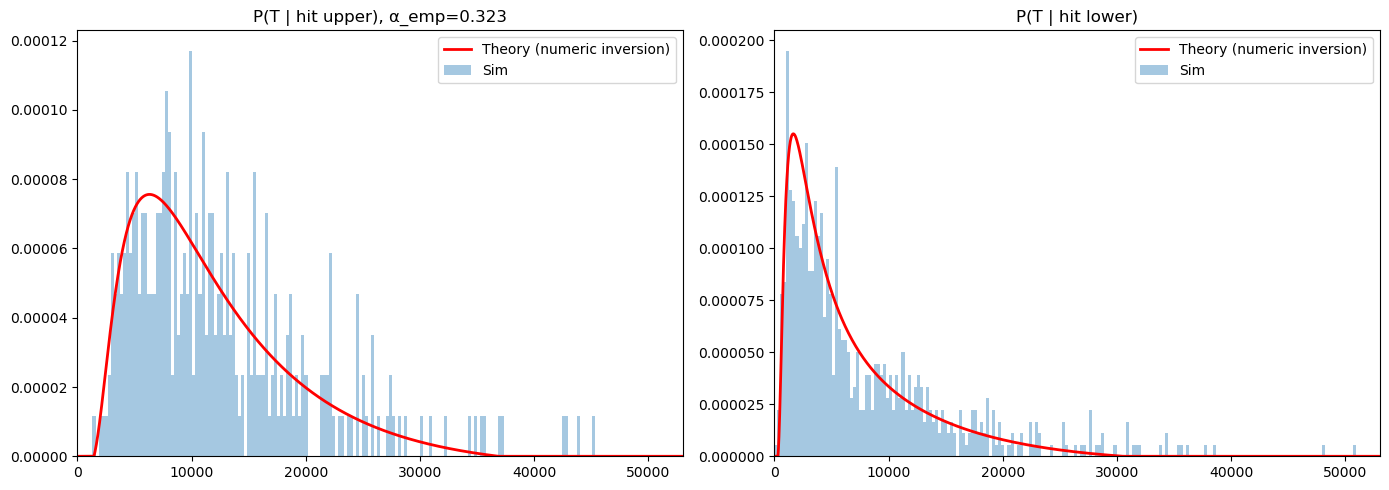

In [25]:

# --- Parameters (same as before) ---
L1 = 1.0
L2 = 1.0
phi0 = 200
S0 = phi0
a = 2 * phi0
b = 0.5 * phi0

# --- Simulate once (or load Ta, Tb from previous block) ---
# (If you already have Ta, Tb from an earlier cell, skip this sim.)
def simulate_skellam(L1, L2, S0, a, b, trials=30000, rng=None):
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []
    for _ in range(trials):
        S = S0; T = 0
        while b < S < a:
            S += rng.poisson(L1) - rng.poisson(L2)
            T += 1
        if S >= a:
            Ta.append(T)
        else:
            Tb.append(T)
    return np.array(Ta), np.array(Tb)

Ta, Tb = simulate_skellam(L1, L2, S0, a, b, trials=1000)
alpha_emp = len(Ta) / (len(Ta)+len(Tb))

# --- Build a stable function for Skellam roots R1( i ω ), R2( i ω ) ---
def skellam_roots_tau(tau, L1, L2):
    A = L1 + L2 - tau
    D = np.sqrt(A*A - 4*L1*L2)
    r1 = (A + D) / (2*L1)
    r2 = (A - D) / (2*L1)
    R1 = np.log(r1)
    R2 = np.log(r2)
    # ensure ordering by real part (stable branch)
    swap = np.real(R1) < np.real(R2)
    if np.isscalar(tau):
        if swap:
            R1, R2 = R2, R1
    else:
        R1[swap], R2[swap] = R2[swap], R1[swap]
    return R1, R2

# --- Define omega grid (real frequencies) and corresponding imaginary tau = i*omega ---
omega_max = 0.02  # extend if pmf has slower decay; increase to reduce ringing
N_omega = 2001
omega = np.linspace(-omega_max, omega_max, N_omega)
tau = 1j * omega

# --- compute roots and stable CCFs on that grid ---
R1, R2 = skellam_roots_tau(tau, L1, L2)

# theoretical alpha (h0)
if L1 != L2:
    h0 = np.log(L2 / L1)
    alpha_th = (np.exp(h0*S0) - np.exp(h0*b)) / (np.exp(h0*a) - np.exp(h0*b))
else:
    alpha_th = (S0 - b) / (a - b)

# stable CCF evaluator (vectorized)
eps = 1e-300
num_a = np.exp(S0*R1 + b*R2) - np.exp(b*R1 + S0*R2)
den = np.exp(a*R1 + b*R2) - np.exp(b*R1 + a*R2)
den = np.where(np.abs(den) < eps, np.sign(den)*eps + eps, den)
CFa_th_omega = num_a / (alpha_th * den)      # this is ψ_T|a(i ω)

# --- empirical CCF on same omega grid (for visualization) ---
CFa_emp_omega = np.array([np.mean(np.exp(Ta * (1j*w))) for w in omega])  # note: exp(T * i ω)

# --- numerical inversion: trapezoidal rule for p[n] up to n_max ---
# choose n_max consistent with histogram range
n_max = int(np.percentile(Ta, 99.9))  # capture most mass
n_max = max(n_max, 1000)             # ensure reasonable min
n_vals = np.arange(0, n_max + 1)

# perform vectorized inversion: p[n] ≈ (Δω / (2π)) * Σ ψ(i ω_k) e^{-i ω_k n}
domega = omega[1] - omega[0]
exp_matrix = np.exp(-1j * np.outer(omega, n_vals))      # shape (N_omega, n_max+1)
integrand = CFa_th_omega[:, None] * exp_matrix          # broadcast multiply
pmf_a_numeric = (domega / (2*np.pi)) * np.real(np.sum(integrand, axis=0))

# clip small negatives from numerical error
pmf_a_numeric = np.maximum(pmf_a_numeric, 0.0)
# renormalize conditional pmf for convenience (optional)
pmf_a_numeric /= (pmf_a_numeric.sum() + 1e-30)

# --- Plot comparison: theory (numeric inverse) + hist ---
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(n_vals, pmf_a_numeric, 'r-', lw=2, label='Theory (numeric inversion)')
plt.hist(Ta, bins=200, range=(0, n_max), density=True, alpha=0.4, label='Sim', color='C0')
plt.title(f"P(T | hit upper), α_emp={alpha_emp:.3f}")
plt.xlim(0, min(n_max, 60000))
plt.legend()

# do same for lower-bound using CFb:
num_b = np.exp(S0*R1 + a*R2) - np.exp(a*R1 + S0*R2)
den_b = np.exp(b*R1 + a*R2) - np.exp(a*R1 + b*R2)
den_b = np.where(np.abs(den_b) < eps, np.sign(den_b)*eps + eps, den_b)
CFb_th_omega = num_b / ((1-alpha_th) * den_b)

exp_matrix_b = np.exp(-1j * np.outer(omega, n_vals))
integrand_b = CFb_th_omega[:, None] * exp_matrix_b
pmf_b_numeric = (domega / (2*np.pi)) * np.real(np.sum(integrand_b, axis=0))
pmf_b_numeric = np.maximum(pmf_b_numeric, 0.0)
pmf_b_numeric /= (pmf_b_numeric.sum() + 1e-30)

plt.subplot(122)
plt.plot(n_vals, pmf_b_numeric, 'r-', lw=2, label='Theory (numeric inversion)')
plt.hist(Tb, bins=200, range=(0, n_max), density=True, alpha=0.4, label='Sim', color='C0')
plt.title("P(T | hit lower)")
plt.xlim(0, min(n_max, 60000))
plt.legend()
plt.tight_layout()
plt.show()


## Linear Voltage Model — Small-Amplitude Case

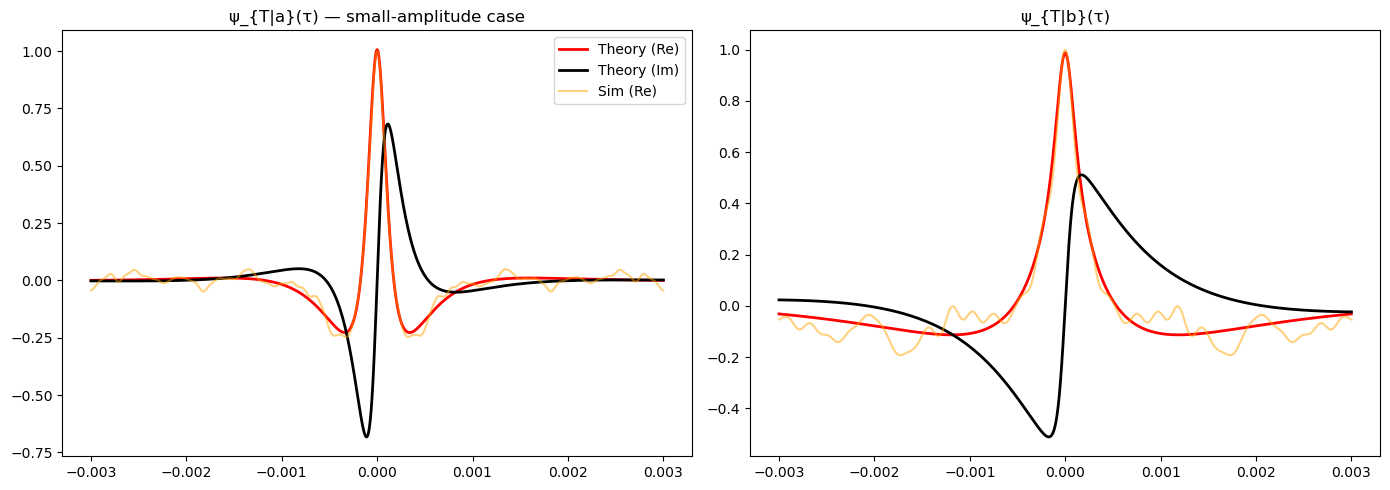

In [27]:
# ---- Parameters ----
L1 = 1.0
L2 = 1.0
phi0 = 200

S0 = phi0
a = 2 * phi0
b = 0.5 * phi0

c1 = 1.02
c2 = 0.01

N_tau = 2001
tau = np.linspace(-0.003, 0.003, N_tau) * 1j


# ---- Simulation ----
def simulate_linear_voltage(L1, L2, c1, c2, S0, a, b, trials=20000, rng=None):
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []
    for _ in range(trials):
        S, T = S0, 0
        while b < S < a:
            S += c1*(rng.poisson(L1) - rng.poisson(L2)) + c2
            T += 1
        (Ta if S >= a else Tb).append(T)
    return np.array(Ta), np.array(Tb)

Ta, Tb = simulate_linear_voltage(L1, L2, c1, c2, S0, a, b, trials=1000)
alpha_emp = len(Ta) / (len(Ta) + len(Tb))


# ---- Theoretical roots (quadratic approx) ----
EV  = c2
EV2 = c1**2 * 2 + c2**2
h0  = -2 * EV / EV2

A = c1**2 + c2**2/2
B = c2
C = 1 - np.exp(-tau)
h1 = (-B + np.sqrt(B**2 - 4*A*C)) / (2*A)
h2 = (-B - np.sqrt(B**2 - 4*A*C)) / (2*A)


# ---- Theoretical CCFs ----
CFa_th = (np.exp(S0*h1 + b*h2) - np.exp(b*h1 + S0*h2)) / \
         (alpha_emp * (np.exp(a*h1 + b*h2) - np.exp(b*h1 + a*h2)))

CFb_th = (np.exp(S0*h1 + a*h2) - np.exp(a*h1 + S0*h2)) / \
         ((1-alpha_emp) * (np.exp(b*h1 + a*h2) - np.exp(a*h1 + b*h2)))


# ---- Empirical CCFs ----
CFa_emp = np.array([np.mean(np.exp(Ta*t)) for t in tau])
CFb_emp = np.array([np.mean(np.exp(Tb*t)) for t in tau])


# ---- Plot ----
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(tau.imag, CFa_th.real, 'r', lw=2, label="Theory (Re)")
plt.plot(tau.imag, CFa_th.imag, 'k', lw=2, label="Theory (Im)")
plt.plot(tau.imag, CFa_emp.real, 'orange', alpha=0.5, label="Sim (Re)")
plt.title("ψ_{T|a}(τ) — small-amplitude case")
plt.legend()

plt.subplot(122)
plt.plot(tau.imag, CFb_th.real, 'r', lw=2)
plt.plot(tau.imag, CFb_th.imag, 'k', lw=2)
plt.plot(tau.imag, CFb_emp.real, 'orange', alpha=0.5)
plt.title("ψ_{T|b}(τ)")

plt.tight_layout()
plt.show()


## Generic SPRT Figure

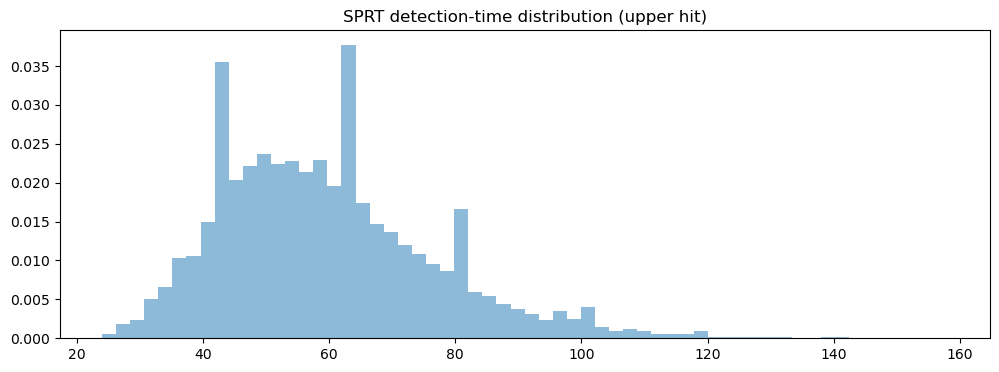

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Example increment model for SPRT ----
p0, p1 = 0.3, 0.7

def ll_increment(rng):
    x = rng.random() < p1
    return np.log(p1/p0) if x else np.log((1-p1)/(1-p0))

# ---- Simulation ----
def simulate_sprt(increment_fn, a, b, S0=0, trials=20000, rng=None):
    rng = np.random.default_rng(rng)
    Ta, Tb = [], []
    for _ in range(trials):
        S, T = S0, 0
        while b < S < a:
            S += increment_fn(rng)
            T += 1
        (Ta if S >= a else Tb).append(T)
    return np.array(Ta), np.array(Tb)

a = 20
b = -20
Ta, Tb = simulate_sprt(ll_increment, a, b, trials=10000)
alpha_emp = len(Ta)/ (len(Ta)+len(Tb))

# ---- Plot ----
plt.figure(figsize=(12,4))
plt.hist(Ta, bins=60, density=True, alpha=0.5)
plt.title("SPRT detection-time distribution (upper hit)")
plt.show()
